# TSP Environment - test import

In [1]:
# rich tracebacks
import rich
import rich.traceback

rich.traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7fab4c19b310>>

In [14]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../../')

import math
from typing import List, Tuple, Optional, NamedTuple, Dict, Union
from einops import rearrange, repeat

import torch
from torch import nn
from torch.utils.checkpoint import checkpoint
from torch.nn import DataParallel
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchrl.envs import EnvBase
from torchrl.envs.utils import step_mdp
from tensordict import TensorDict

from copy import deepcopy
from hydra.utils import instantiate



from graph_encoder import GraphAttentionEncoder
from attention import CrossAttention
from utils import CachedLookup, sample_many
from reinforce_baselines import *

from ncobench.envs import TSPEnv

# from ncobench.envs.archive.tsp_ids import TSPEnv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Rollout

In [3]:
# random tensor of shape torch.Size([128, 5, 2])
a = torch.rand(128, 5, 2)
# torch.Size([128, 1])
ids = torch.randint(0, 5, (128, 1))
#torch.Size([128, 1])
prev_a = torch.randint(0, 5, (128, 1))

# a[ids].shape
# a[prev_a].shape
# given `prev_a` indices, get the corresponding `a` values with index_select
a.index_select(0, prev_a.squeeze(1)).shape
# a[prev_a].shape


result = torch.gather(a, 1, prev_a.unsqueeze(-1).repeat(1, 1, 2))
result.shape

torch.Size([128, 1, 2])

In [8]:
# Reset the environment: call new one to enable new seeding after check_env_specs
env = TSPEnv(n_loc=10)
# env.set_seed(888)

rollout_ = env.rollout(
    50,
    auto_reset=False,  # we're executing the reset out of the ``rollout`` call
    tensordict=env.reset(env.gen_params(batch_size=[128])),
    break_when_any_done=True
)

print(rollout_)

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([128, 13, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        cur_coord: Tensor(shape=torch.Size([128, 13, 1, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        dist: Tensor(shape=torch.Size([128, 13, 10, 10]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([128, 13, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        first_a: Tensor(shape=torch.Size([128, 13, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        i: Tensor(shape=torch.Size([128, 13, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        lengths: Tensor(shape=torch.Size([128, 13, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        loc: Tensor(shape=torch.Size([128, 13, 10, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                cur_coord: Tensor(shape=torch.Size([128, 13, 1, 2]), device=cpu, dty

### Plotting

Batch detected. Plotting the first batch element!


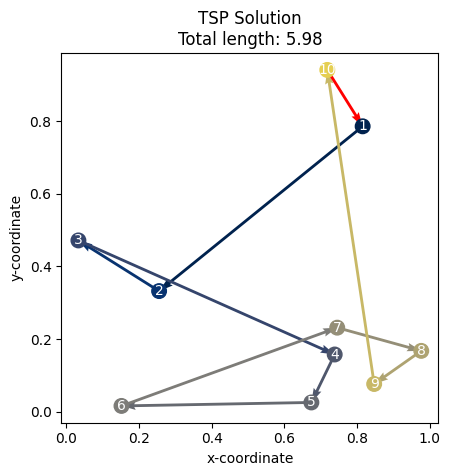

In [9]:
# get greater than -inf reward indexes
last_state = rollout_['next'][:, -1]
idx = last_state["reward"] > -float('inf')
rollout_finished = last_state[idx.squeeze()]

env.plot(rollout_finished)

## REINFORCE Baselines

## Utils

In [10]:
# def set_decode_type(model, decode_type):
#     if isinstance(model, DataParallel):
#         model = model.module
#     model.set_decode_type(decode_type)


class AttentionModelFixed(NamedTuple):
    """
    Context for AttentionModel decoder that is fixed during decoding so can be precomputed/cached
    This class allows for efficient indexing of multiple Tensors at once
    """
    node_embeddings: torch.Tensor
    context_node_projected: torch.Tensor
    glimpse_key: torch.Tensor
    glimpse_val: torch.Tensor
    logit_key: torch.Tensor

    def __getitem__(self, key):
        assert torch.is_tensor(key) or isinstance(key, slice)
        return AttentionModelFixed(
            node_embeddings=self.node_embeddings[key],
            context_node_projected=self.context_node_projected[key],
            glimpse_key=self.glimpse_key[:, key],  # dim 0 are the heads
            glimpse_val=self.glimpse_val[:, key],  # dim 0 are the heads
            logit_key=self.logit_key[key]
        )

## AttentionModelBase

Here we declare the `AttentionModelBase`, which is the `nn.Module`:
- Given initial states, it returns the solutions and rewards for them
- We then wrap the main model with REINFORCE baselines and epoch callbacks to train it (full `AttentionModel`)

In [11]:
class AttentionModelBase(nn.Module):

    def __init__(self,
                 env: EnvBase,
                 embedding_dim: int,
                 hidden_dim: int,
                 *,
                 n_encode_layers: int = 2,
                 tanh_clipping: float = 10.,
                 mask_inner: bool = True,
                 mask_logits: bool = True,
                 normalization: str = 'batch',
                 n_heads: int = 8,
                 checkpoint_encoder: bool = False,
                 use_flash_attn: bool = False,
                 **kwargs
                 ):
        super(AttentionModelBase, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_encode_layers = n_encode_layers
        self.decode_type = None
        self.temp = 1.0
        self.env = env

        self.tanh_clipping = tanh_clipping

        self.mask_inner = mask_inner
        self.mask_logits = mask_logits

        self.n_heads = n_heads
        self.checkpoint_encoder = checkpoint_encoder

        # TODO: add extra except TSP
        step_context_dim = 2 * embedding_dim  # Embedding of first and last node
        node_dim = 2  # x, y
        
        # Learned input symbols for first action
        self.W_placeholder = nn.Parameter(torch.Tensor(2 * embedding_dim))
        self.W_placeholder.data.uniform_(-1, 1)  # Placeholder should be in range of activations

        self.init_embed = nn.Linear(node_dim, embedding_dim)

        self.embedder = GraphAttentionEncoder(
            n_heads=n_heads,
            embed_dim=embedding_dim,
            n_layers=self.n_encode_layers,
            normalization=normalization,
            use_flash_attn=use_flash_attn,
        )
        
        self.cross_attention = CrossAttention() # NOTE: FlashCrossAttention does not support inner masking!

        # For each node we compute (glimpse key, glimpse value, logit key) so 3 * embedding_dim
        self.project_node_embeddings = nn.Linear(embedding_dim, 3 * embedding_dim, bias=False)
        self.project_fixed_context = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.project_step_context = nn.Linear(step_context_dim, embedding_dim, bias=False)
        assert embedding_dim % n_heads == 0
        # Note n_heads * val_dim == embedding_dim so input to project_out is embedding_dim
        self.project_out = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def set_decode_type(self, decode_type, temp=None):
        self.decode_type = decode_type
        if temp is not None:  # Do not change temperature if not provided
            self.temp = temp

    def forward(self, td: TensorDict) -> TensorDict:
        """Given observation, precompute embeddings and rollout"""

        if self.checkpoint_encoder and self.training:  # Only checkpoint if we need gradients
            embeddings, _ = checkpoint(self.embedder, self._init_embed(td['observation']))
        else:
            embeddings, _ = self.embedder(self._init_embed(td['observation']))

        _log_p, pi, td = self._rollout(td, embeddings)

        reward = td['reward']
        mask = td.get('mask', None)

        # Log likelyhood is calculated within the model since returning it per action does not work well with
        # DataParallel since sequences can be of different lengths
        ll = self._calc_log_likelihood(_log_p, pi, mask)
        out = {"reward": reward, "log_likelihood": ll, "actions": pi}
        return out
    
    def _rollout(self, td, embeddings):

        outputs = []
        sequences = []

        # Compute keys, values for the glimpse and keys for the logits once as they can be reused in every step
        fixed = self._precompute(embeddings)

        while not td["done"].any(): # NOTE: here we suppose all the batch is done at the same time
            
            log_p, mask = self._get_log_p(fixed, td)

            # Select the indices of the next nodes in the sequences, result (batch_size) long
            selected = self._select_node(log_p.exp()[:, 0, :], mask[:, 0, :])  # Squeeze out steps dimension
           
            td.set("action", selected[:, None])
            td = self.env.step(td)['next']

            # Collect output of step
            outputs.append(log_p[:, 0, :])
            sequences.append(selected)

        # Collected lists, return Tensor
        return torch.stack(outputs, 1), torch.stack(sequences, 1), td

    def _calc_log_likelihood(self, _log_p, a, mask):

        # Get log_p corresponding to selected actions
        log_p = _log_p.gather(2, a.unsqueeze(-1)).squeeze(-1)

        # Optional: mask out actions irrelevant to objective so they do not get reinforced
        if mask is not None:
            log_p[mask] = 0

        assert (log_p > -1000).data.all(), "Logprobs should not be -inf, check sampling procedure!"

        # Calculate log_likelihood
        return log_p.sum(1)

    def _init_embed(self, x):
        # TODO: others except TSP
        return self.init_embed(x)
    
    def _select_node(self, probs, mask):

        assert (probs == probs).all(), "Probs should not contain any nans"

        if self.decode_type == "greedy":
            _, selected = probs.max(1)
            assert not mask.gather(1, selected.unsqueeze(
                -1)).data.any(), "Decode greedy: infeasible action has maximum probability"

        elif self.decode_type == "sampling":
            selected = probs.multinomial(1).squeeze(1)

            # Check if sampling went OK, can go wrong due to bug on GPU
            # See https://discuss.pytorch.org/t/bad-behavior-of-multinomial-function/10232
            while mask.gather(1, selected.unsqueeze(-1)).data.any():
                print('Sampled bad values, resampling!')
                selected = probs.multinomial(1).squeeze(1)

        else:
            assert False, "Unknown decode type"
        return selected

    def _precompute(self, embeddings, num_steps=1):

        # The fixed context projection of the graph embedding is calculated only once for efficiency
        graph_embed = embeddings.mean(1)
        # fixed context = (batch_size, 1, embed_dim) to make broadcastable with parallel timesteps
        fixed_context = self.project_fixed_context(graph_embed)[:, None, :]

        # The projection of the node embeddings for the attention is calculated once up front
        glimpse_key_fixed, glimpse_val_fixed, logit_key_fixed = \
            self.project_node_embeddings(embeddings[:, None, :, :]).chunk(3, dim=-1)
        
        # No need to rearrange key for logit as there is a single head
        fixed_attention_node_data = (
            self._make_heads(glimpse_key_fixed, num_steps),
            self._make_heads(glimpse_val_fixed, num_steps),
            logit_key_fixed.contiguous()
        )
        return AttentionModelFixed(embeddings, fixed_context, *fixed_attention_node_data)

    def _get_log_p(self, fixed, td, normalize=True):
        
        # Compute query = context node embedding
        query = fixed.context_node_projected + \
                self.project_step_context(self._get_parallel_step_context(fixed.node_embeddings, td))

        # Compute keys and values for the nodes
        glimpse_K, glimpse_V, logit_K = self._get_attention_node_data(fixed, td['observation'])

        # Compute the mask
        mask = self.env.get_mask(td)

        # Compute logits (unnormalized log_p)
        log_p, glimpse = self._one_to_many_logits(query, glimpse_K, glimpse_V, logit_K, mask)

        if normalize:
            log_p = torch.log_softmax(log_p / self.temp, dim=-1)

        assert not torch.isnan(log_p).any()

        return log_p, mask

    def _get_parallel_step_context(self, embeddings, td, from_depot=False):
        """
        Returns the context per step, optionally for multiple steps at once (for efficient evaluation of the model)
        
        :param embeddings: (batch_size, graph_size, embed_dim)
        :param prev_a: (batch_size, num_steps)
        :param first_a: Only used when num_steps = 1, action of first step or None if first step
        :return: (batch_size, num_steps, context_dim)
        """

        current_node = self.env.get_current_node(td)
        batch_size, num_steps = current_node.size()

        # TODO: add others except TSP
        if num_steps == 1:  # We need to special case if we have only 1 step, may be the first or not
            if td['i'][0].item() == 0: # TODO check
                # First and only step, ignore prev_a (this is a placeholder)
                return self.W_placeholder[None, None, :].expand(batch_size, 1, self.W_placeholder.size(-1))
            else:
                return embeddings.gather(
                    1,
                    torch.cat((td['first_a'], current_node), 1)[:, :, None].expand(batch_size, 2, embeddings.size(-1))
                ).view(batch_size, 1, -1)
        # More than one step, assume always starting with first
        embeddings_per_step = embeddings.gather(
            1,
            current_node[:, 1:, None].expand(batch_size, num_steps - 1, embeddings.size(-1))
        )
        return torch.cat((
            # First step placeholder, cat in dim 1 (time steps)
            self.W_placeholder[None, None, :].expand(batch_size, 1, self.W_placeholder.size(-1)),
            # Second step, concatenate embedding of first with embedding of current/previous (in dim 2, context dim)
            torch.cat((
                embeddings_per_step[:, 0:1, :].expand(batch_size, num_steps - 1, embeddings.size(-1)),
                embeddings_per_step
            ), 2)
        ), 1)

    def _one_to_many_logits(self, query, key, value, logit_K, mask):

        batch_size, num_steps, embed_dim = query.size()
        key_size = val_size = embed_dim // self.n_heads

        # TODO: no need to rearrange with refactor
        kv = torch.stack([key, value])
        q = rearrange(query, 'b 1 (h s) -> b 1 h s', h=self.n_heads)
        kv = rearrange(kv, 'two h b 1 g s -> b g two h s', two=2, h=self.n_heads)     

        # 1 means to keep, so we invert the mask
        key_padding_mask = ~mask.squeeze()
        heads = self.cross_attention(q, kv, key_padding_mask=key_padding_mask)

        heads = rearrange(heads, 'b 1 h g -> h b 1 1 g')

        # Project to get glimpse/updated context node embedding (batch_size, num_steps, embedding_dim)
        glimpse = self.project_out(
            heads.permute(1, 2, 3, 0, 4).contiguous().view(-1, num_steps, 1, self.n_heads * val_size))
        
        # Batch matrix multiplication to compute logits (batch_size, num_steps, graph_size)
        # logits = 'compatibility'
        logits = torch.matmul(glimpse, logit_K.transpose(-2, -1)).squeeze(-2) / math.sqrt(glimpse.size(-1))

        # From the logits compute the probabilities by clipping, masking and softmax
        if self.tanh_clipping > 0:
            logits = torch.tanh(logits) * self.tanh_clipping
        if self.mask_logits:
            logits[mask] = -math.inf

        return logits, glimpse.squeeze(-2)

    def _get_attention_node_data(self, fixed: AttentionModelFixed, td: TensorDict) -> dict:
        # TODO: add others except TSP
        # TSP or VRP without split delivery
        return fixed.glimpse_key, fixed.glimpse_val, fixed.logit_key

    def _make_heads(self, v, num_steps=None):
        # TODO: refactor so no need for rearrange
        assert num_steps is None or v.size(1) == 1 or v.size(1) == num_steps

        return (
            v.contiguous().view(v.size(0), v.size(1), v.size(2), self.n_heads, -1)
            .expand(v.size(0), v.size(1) if num_steps is None else num_steps, v.size(2), self.n_heads, -1)
            .permute(3, 0, 1, 2, 4)  # (n_heads, batch_size, num_steps, graph_size, head_dim)
        )
    
    def beam_search(self, *args, **kwargs):
        return self.problem.beam_search(*args, **kwargs, model=self)

    def precompute_fixed(self, x):
        embeddings, _ = self.embedder(self._init_embed(x))
        # Use a CachedLookup such that if we repeatedly index this object with the same index we only need to do
        # the lookup once... this is the case if all elements in the batch have maximum batch size
        return CachedLookup(self._precompute(embeddings))

    def sample_many(self, x, batch_rep=1, iter_rep=1):
        # Bit ugly but we need to pass the embeddings as well.
        # Making a tuple will not work with the problem.get_cost function
        return sample_many(
            lambda x: self._inner(*x),  # Need to unpack tuple into arguments
            lambda x, pi: self.problem.get_costs(x[0], pi),  # Don't need embeddings as input to get_costs
            (x, self.embedder(self._init_embed(x))[0]),  # Pack input with embeddings (additional input)
            batch_rep, iter_rep
        )

## Test `AttentionModelBase`

In [13]:
class TorchDictDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx] # note: use torch.stack to get batch
    

env = TSPEnv(n_loc=20)
env = env.transform()

data = env.gen_params(batch_size=[1024]) # NOTE: need to put batch_size in a list!!
init_td = env.reset(data)
dataset = TorchDictDataset(init_td)

dataloader = DataLoader(
                dataset,
                batch_size=128,
                shuffle=False, # no need to shuffle, we're resampling every epoch
                num_workers=0,
                collate_fn=torch.stack, # we need this to stack the batches in the dataset
            )


model = AttentionModelBase(
    env,
    embedding_dim=128,
    hidden_dim=128,
    n_encode_layers=3,
) #.to("cuda")

# set_decode_type(model, "greedy")
model.set_decode_type("greedy")

# model = torch.compile(model, backend="cuda")


x = next(iter(dataloader))


out = model(x)
print(out['reward'].shape)

torch.Size([128, 1])


In [9]:

model = deepcopy(model)

In [10]:
train_dataloader = dataloader

baseline = instantiate({"_target_": "__main__.WarmupBaseline",
                        "baseline": {"_target_": "__main__.RolloutBaseline",                                        }
                        })



In [ ]:
from hydra.utils import instantiate


class AttentionModel(nn.Module):
    def __init__(self, env, policy):
        super().__init__()
        self.env = env
        self.policy = policy

        # TODO: hydra instantiation
        # self.policy = instantiate(cfg.policy)
        # self.baseline = instantiate(cfg.baseline) TODO

    def forward(self, td: TensorDict) -> TensorDict:
        """Evaluate model, get costs and log probabilities and compare with baseline"""
 
        # Evaluate model, get costs and log probabilities
        model_out = self.policy(td)
        cost = -model_out['reward']
        log_likelihood = model_out['log_likelihood']

        bl_val, bl_loss = self.baseline.eval(x, cost)

        # Calculate loss
        advantage = cost - bl_val
        reinforce_loss = (advantage * log_likelihood).mean()
        loss = reinforce_loss + bl_loss

        return {'loss': loss, 'reinforce_loss': reinforce_loss, 'bl_loss': bl_loss, 'bl_val': bl_val, **model_out}
    
    def setup(self, pl_module):
        # Make baseline taking model itself and train_dataloader from model as input
        # TODO make this as taken from config
        self.baseline = instantiate({"_target_": "__main__.WarmupBaseline",
                                    "baseline": {"_target_": "__main__.RolloutBaseline",
                                                "_args_": [model, pl_module.train_dataloader]
                                                }
                                    })   
        # self.baseline = NoBaseline()                            
        
    def on_train_epoch_end(self, pl_module):
        self.baseline.epoch_callback(self, pl_module.train_dataloader(), pl_module.current_epoch)

## Lightning Module

In [12]:
policy = AttentionModelBase(
    env,
    embedding_dim=128,
    hidden_dim=128,
    n_encode_layers=3,
) #.to("cuda")


model_fake = AttentionModel(env, policy)

# model_fake.policy.set_decode_type("greedy")
# baseline.setup(model_fake, train_dataloader)

In [13]:
import lightning as L
from typing import Any


class NCOLightningModule(L.LightningModule):
    def __init__(self, env, model, lr=1e-4, batch_size=128, batches_per_epoch=1000):
        super().__init__()

        # TODO: hydra instantiation
        self.env = env
        self.model = model
        self.lr = lr
        self.batch_size = batch_size
        self.batches_per_epoch = batches_per_epoch
        self.setup()

    def setup(self, stage="fit"):
        self._generate_data()
        if hasattr(self.model, "setup"):
            self.model.setup(self)

    def shared_step(self, batch: Any, batch_idx: int, phase: str):
        output = self.model(batch)
        self.log(f"{phase}_reward", output["reward"].mean(), prog_bar=True)
        return {"loss": output['loss']}

    def training_step(self, batch: Any, batch_idx: int):    
        return self.shared_step(batch, batch_idx, phase='train')

    def validation_step(self, batch: Any, batch_idx: int):
        return self.shared_step(batch, batch_idx, phase='val')

    def test_step(self, batch: Any, batch_idx: int):
        return self.shared_step(batch, batch_idx, phase='test')

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        # TODO: scheduler
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, total_steps)
        return [optim] #, [scheduler]
    
    def train_dataloader(self):
        return self._dataloader()
    
    # def val_dataloader(self):
    #     return self._dataloader()
    
    # def test_dataloader(self):
    #     return self._dataloader()
    
    def on_train_epoch_end(self):
        self._generate_data()
        if hasattr(self.model, "on_train_epoch_end"):
            self.model.on_train_epoch_end(self)

    def _generate_data(self):
        # Online data generation: we generate a new batch every epoch
        data = self.env.gen_params(batch_size=self.batches_per_epoch)
        init_td = self.env.reset(data)
        self.dataset = TorchDictDataset(init_td)
           
    def _dataloader(self):
        return DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            shuffle=False, # no need to shuffle, we're resampling every epoch
            num_workers=0,
            collate_fn=torch.stack, # we need this to stack the batches in the dataset
        )

In [15]:
env = TSPEnv(n_loc=20)
env = env.transform()
policy = AttentionModelBase(
    env,
    embedding_dim=128,
    hidden_dim=128,
    n_encode_layers=3,
)

model_final = AttentionModel(env, policy).to("cuda:0")


policy.set_decode_type("greedy")

model = NCOLightningModule(env, model_final, batch_size=10024, batches_per_epoch=100000, lr=1e-4)

# Trick to make calculations faster
torch.set_float32_matmul_precision("medium")

# Wandb Logger - we can use others as well as simply `None`
# logger = pl.loggers.WandbLogger(project="torchrl", name="pendulum")
# logger = L.loggers.CSVLogger("logs", name="tsp")

epochs = 10

# Trainer
trainer = L.Trainer(
    max_epochs=epochs,
    num_nodes=1,
    devices=1,
    accelerator="cuda",
    # logger=logger,
    log_every_n_steps=1,   
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients
)

# Fit the model
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type           | Params
-----------------------------------------
0 | env   | TransformedEnv | 0     
1 | model | AttentionModel | 710 K 
-----------------------------------------
710 K     Trainable params
0         Non-trainable params
710 K     Total params
2.841     Total estimated model params size (MB)


Epoch 1:  20%|██        | 2/10 [00:02<00:10,  1.27s/it, v_num=64, train_reward=-10.4] 